<a href="https://colab.research.google.com/github/harikrishhnanC98/hcnlp_football_analysis/blob/main/nonfinetuned_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import auth
auth.authenticate_user()

!git config --global user.name "harikrishhnanC98"

# Generate a personal access token (PAT) from GitHub and paste it when prompted
from getpass import getpass
token = getpass('Enter your GitHub token: ')

!git clone https://{token}@github.com/harikrishhnanC98/hcnlp_football_analysis.git


Enter your GitHub token: ··········
Cloning into 'hcnlp_football_analysis'...
remote: Enumerating objects: 574, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 574 (delta 85), reused 58 (delta 36), pack-reused 450 (from 2)
Receiving objects: 100% (574/574), 481.85 MiB | 13.46 MiB/s, done.
Resolving deltas: 100% (261/261), done.
Updating files: 100% (270/270), done.


In [2]:
# ⚙️ Basic setup(use this if any error occurs for the next)
!pip install -q unsloth[torch] transformers datasets peft accelerate bitsandbytes trl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.5/31.5 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
%cd /content/hcnlp_football_analysis

/content/hcnlp_football_analysis


In [4]:
import json

# Load updated JSON with centralities included
with open("/content/hcnlp_football_analysis/test_data/match_7_first_half.json", "r") as f:
    data = json.load(f)

# Format player pass and centrality metrics
pass_network_text = ""
for player, stats in data["pass_network"].items():
    pass_network_text += (
        f"- {player}: "
        f"{stats['passes_made']} passes made, "
        f"{stats['passes_received']} received, "
        f"Degree: {stats['degree_centrality']:.2f}, "
        f"Betweenness: {stats['betweenness_centrality']:.2f}, "
        f"Closeness: {stats['closeness_centrality']:.2f}, "
        f"PageRank: {stats['pagerank']:.2f}, "
        f"Eigenvector: {stats['eigenvector_centrality']:.2f}, "
        f"Clustering: {stats['clustering']:.2f}\n"
    )

# Format graph-level metrics
graph = data["graph_metrics"]
graph_text = (
    f"The overall passing network had {graph['num_nodes']} players and {graph['num_edges']} total passes. represented as graph edges between players). This count of {graph['num_edges']} passes avoids double-counting and reflects the actual network structure, where each edge is a pass between two players. "
    f"Network density: {graph['density']:.3f}, "
    f"Average clustering coefficient: {graph['avg_clustering']:.3f}."
)

In [5]:
import os
import subprocess

# Define your prompts
prompt1 = f"""
You are an expert in football data analysis, specialized in predicting match outcomes based on pass network data. You have been fine-tuned on pass networks (created using StatsBomb player pass stats), match statistics, and text reports from Argentina's previous six matches in the 2022 World Cup.
**Assume the second half of the final has not happened yet.**

DO NOT:
- Invent or guess numbers (e.g., "75% possession" or "passes made")
- Mention the goalkeeper (exclude Emiliano Martínez)
- Refer to a player without citing their stats
- Skip any section or provide vague reasoning

Below given are the players and their positions where FW-forward, LM-Left midfield, CM-Central midfield, RM-Right midfield, LB-Left back, CB-Centre back, RB-Right back, GK-Goalkeeper:
- **Do not mix up player positions. Always follow the positions mentioned below**
Lautaro Martínez	FW
Lionel Messi	FW - Starting 11
Papu Gómez		LM
Julián Álvarez	LM - Starting 11
Leandro Paredes	CM
Enzo Fernández	CM - Starting 11
Rodrigo De Paul	CM - Starting 11
Ángel Di María	RM - Starting 11
Nicolás Tagliafico	LB - Starting 11
Marcos Acuña	LB
Nicolás Otamendi	CB - Starting 11
Cristian Romero 	CB - Starting 11
Lisandro Martínez	CB
Nahuel Molina	RB - Starting 11
Emiliano Martínez	GK - Starting 11

**The player names with '- Starting 11' indicate the players who started the match.**

**First Half Formation**
Argentina Formation - 4-3-3

**First Half Goals**

23rd minute: Lionel Messi converted a penalty after Ángel Di María was fouled in the box by Ousmane Dembélé.
36th minute: Ángel Di María finished a swift team move, doubling Argentina's lead. Key pass Assist was made by Alexis Mac Allister.

**Key First-Half Statistics**

Possession: Argentina held 55% of the ball, while France had 45%.
Shots on Target: Argentina registered 5 shots on goal; France had none.
Total Shots: Argentina attempted 10 shots; France managed 7.
Corners: Argentina earned 6 corners; France had 5.
Fouls Committed: Argentina committed 26 fouls; France committed 19.
Yellow Cards: Argentina received 5 yellow cards; France received 3.

**First-Half Pass Network Summary**:
{pass_network_text}

**First-Half Graph-Level Summary**:
{graph_text}


Please respond using the following structure and only based on the input data provided:

**1. Influential Passes and Players**
- Identify specific passes leading to goals or scoring opportunities.
- Include player names, positions, and relevant pass metrics (passes made, received, centrality values).

**2. Tactical Suggestions for the Second Half**
- Recommend:
  a) Substitutions (who and why, based on passes made/received and centrality).
  b) Pass totals (from graph metrics)
  c) Positional changes (e.g., shift Di María inward, or allow Fernández more forward freedom).
  d) Formation tweaks (e.g., overload left side if pass clustering is higher there).
- Always support suggestions with exact stats.

**3. Positive/Favorable Situations**
- Highlight passing patterns that led to shots, space creation, or domination in zones.

**4. Overall Inference**
- Assess Argentina’s first-half using:
  a) Possession (%)
  b) Network density and clustering coefficient
  c) Player-specific centrality metrics
- Provide:
  a) 2 specific suggestions to improve second-half passing efficiency
  b) Predict which player (with stats) is most likely to impact the second half positively.

### Final Instructions

- **Be careful and provide only the actual values from the input data**
- **Use accurate metrics when discussing player impact**
- **Avoid general football commentary**
- **Exclude Damián Emiliano Martínez (GK) from tactical analysis**
- **Strictly follow the input and do not hallucinate new data**
- **Each player mention must include at least two metrics: passes made, passes received, degree, betweenness, closeness, pagerank, eigenvector, or clustering.
- **Omit general statements like "played well" or "strong control".


###Response
"""

prompt2 = f"""
You are an expert in football data analysis, specialized in predicting match outcomes based on pass network data. You have been fine-tuned on pass networks (created using StatsBomb player pass stats), match statistics, and text reports from Argentina's previous six matches in the 2022 World Cup.
**Assume the second half of the final has not happened yet.**


Below given are the players and their positions where FW-forward, LM-Left midfield, CM-Central midfield, RM-Right midfield, LB-Left back, CB-Centre back, RB-Right back, GK-Goalkeeper:

Lionel Messi	FW - Starting 11
Julián Álvarez	LM - Starting 11
Enzo Fernández	CM - Starting 11
Rodrigo De Paul	CM - Starting 11
Ángel Di María	RM - Starting 11
Nicolás Tagliafico	LB - Starting 11
Nicolás Otamendi	CB - Starting 11
Cristian Romero 	CB - Starting 11
Nahuel Molina	RB - Starting 11


**First Half Formation**
Argentina Formation in the first-half- 4-3-3
23rd minute: Lionel Messi converted a penalty after Ángel Di María was fouled in the box by Ousmane Dembélé.
36th minute: Ángel Di María finished a swift team move, doubling Argentina's lead. Key pass Assist was made by Alexis Mac Allister.
Possession: Argentina held 55% of the ball, while France had 45%.

**First-Half Pass Network Summary**:
{pass_network_text}

**First-Half Graph-Level Summary**:
{graph_text}

Follow these Instructions:

The player names with '- Starting 11' indicate the players who started the match.
There is no information about France stats, so don't use them.
Strictly follow the input and do not hallucinate new data
Using the First-Half Pass Network Summary and First-Half Graph-Level Summary from the 2022 World Cup final (Argentina vs. France), provide the following details for Argentina:

  1. Predict scoreline for second-half based on historical data and first-half network and graph-level summary.
  2. Predict top player based on pass network summary and graph-level summary
  3. Predict expected possesion metric for the second-half
  4. Predict most favourable passing lane and the players included in the passing lane for the second-half
  5. 1 tip to improve top playmaker's contribution
  6. Predict whether Argentina should stick to the same formation 4-3-3 or change formation to suit better passing to properly utilize underutilized players.

###Response
"""

prompt3 = f"""
You are an expert in football data analysis, specialized in predicting match outcomes based on pass network data. You have been fine-tuned on pass networks (created using StatsBomb player pass stats), match statistics, and text reports from Argentina's previous six matches in the 2022 World Cup.

**First Half Formation**
Argentina Formation in the first-half- 4-3-3
23rd minute: Lionel Messi converted a penalty after Ángel Di María was fouled in the box by Ousmane Dembélé.
36th minute: Ángel Di María finished a swift team move, doubling Argentina's lead. Key pass Assist was made by Alexis Mac Allister.
Possession: Argentina held 55% of the ball, while France had 45%.


**Below given are the players who are Argentina's starting 11:**

Lionel Messi	FW - Starting 11
Julián Álvarez	FW - Starting 11
Enzo Fernández	CM - Starting 11
Rodrigo De Paul	CM - Starting 11
Ángel Di María	FW - Starting 11
Nicolás Tagliafico	LB - Starting 11
Nicolás Otamendi	CB - Starting 11
Cristian Romero 	CB - Starting 11
Nahuel Molina	RB - Starting 11

**These are the players who are on Argentina's bench**:
1. Lautaro Martínez (FW):
   - Passes made: 12.8, Passes received: 10.2
   - Degree: 0.59, Betweenness: 0.31, Closeness: 0.56
   - PageRank: 0.47, Eigenvector: 0.50, Clustering: 0.23

2. Lisandro Martínez (CB) - Bench player:
   - Passes made: 15.4, Passes received: 13.7
   - Degree: 0.64, Betweenness: 0.27, Closeness: 0.60
   - PageRank: 0.45, Eigenvector: 0.52, Clustering: 0.28
3. Leandro Paredes (CM)- Bench player:
   - Passes made: 28.5, Passes received: 24.1
   - Degree: 0.78, Betweenness: 0.48, Closeness: 0.75
   - PageRank: 0.66, Eigenvector: 0.68, Clustering: 0.34
4. Marcos Acuña (LB)- Bench player:
   - Passes made: 23.7, Passes received: 21.2
   - Degree: 0.71, Betweenness: 0.38, Closeness: 0.67
   - PageRank: 0.58, Eigenvector: 0.60, Clustering: 0.30
5.  Gonzalo Montiel(RB)- Bench player:
   - Degree Centrality: 0.823, Betweenness Centrality: 0.00875, Closeness Centrality: 0.632
   - Eigenvector Centrality: 0.1766, PageRank: 0.03925, Clustering: 0.9222
   - Passes Made: 22.33, Passes Received: 21.67
6. Germán Pezzella(CB)- Bench player:
    - Degree Centrality: 0.9646, Betweenness Centrality: 0.01539, Closeness Centrality: 0.6739
    - Eigenvector Centrality: 0.1979, PageRank: 0.0333, Clustering: 0.8984
    - Passes Made: 24.0, Passes Received: 20.5


**First-Half metrics of starting players**:
{pass_network_text}

**As Argentina is leading 2-0, focus should be on reducing the risk of counter-attacks and maintaining control of possession.**


**Please respond using the following structure and by comparing First-Half metrics of starting players provided with the average metrics of bench players:**

1. Should Nicolás Otamendi(CB) be replaced by Germán Pezzella(CB) or Lisandro Martínez (CB)?
2. Should Nahuel Molina(RB) be replaced by Gonzalo Montiel(RB)?
3. Should Nicolás Tagliafico(LB) be replaced by Marcos Acuña (LB)?
4. Should Julián Álvarez(FW) be replaced by Lautaro Martínez (FW)?
6. How many of these substitutions should Argentina make?
7. Should Argentina's 4-3-3 formation be changed in the second half to accomodate these substitutions?

###Response
"""
prompt4 = f"""
You are an expert in football data analysis, specialized in predicting match outcomes based on pass network data. You have been fine-tuned on pass networks (created using StatsBomb player pass stats), match statistics, and text reports from Argentina's previous six matches in the 2022 World Cup.

**Assume the second half of the final has not happened yet.**

**First Half Formation**
Argentina Formation - 4-3-3

**First Half Goals**
23rd minute: Lionel Messi converted a penalty after Ángel Di María was fouled in the box by Ousmane Dembélé.
36th minute: Ángel Di María finished a swift team move, doubling Argentina's lead. Key pass Assist was made by Alexis Mac Allister.

**Key First-Half Statistics**
Possession: Argentina held 55% of the ball, while France had 45%.
Shots on Target: Argentina registered 5 shots on goal; France had none.
Total Shots: Argentina attempted 10 shots; France managed 7.
Corners: Argentina earned 6 corners; France had 5.
Fouls Committed: Argentina committed 26 fouls; France committed 19.
Yellow Cards: Argentina received 5 yellow cards; France received 3.

**The answer should be in this format '(score) - (score)' and should not include any other text**

Predict the expected scoreline for the second half based on their first half pass network summary and graph metrics.

###Response
"""
prompt5 = f"""
You are an expert in football data analysis, specialized in predicting match outcomes based on pass network data. You have been fine-tuned on pass networks (created using StatsBomb player pass stats), match statistics, and text reports from Argentina's previous six matches in the 2022 World Cup.

**Assume the second half of the final has not happened yet.**

**First Half Formation**
Argentina Formation - 4-3-3

**First Half Goals**
23rd minute: Lionel Messi converted a penalty after Ángel Di María was fouled in the box by Ousmane Dembélé.
36th minute: Ángel Di María finished a swift team move, doubling Argentina's lead. Key pass Assist was made by Alexis Mac Allister.

**Key First-Half Statistics**
Possession: Argentina held 55% of the ball, while France had 45%.
Shots on Target: Argentina registered 5 shots on goal; France had none.
Total Shots: Argentina attempted 10 shots; France managed 7.
Corners: Argentina earned 6 corners; France had 5.
Fouls Committed: Argentina committed 26 fouls; France committed 19.
Yellow Cards: Argentina received 5 yellow cards; France received 3.

**Only the expected possesion metric for Argentina in the second half. Do not include anything else. I just need the Possession number **

Predict the expected possession for Argentina based on their first half pass network summary in one word.
###Response
"""

prompt6 = """
You are an expert in football data analysis, specialized in predicting match outcomes based on pass network data. You have been fine-tuned on pass networks (created using StatsBomb player pass stats), match statistics, and text reports from Argentina's previous six matches in the 2022 World Cup.

**Assume the second half of the final has not happened yet.**

**First Half Formation**
Argentina Formation - 4-3-3

**First Half Goals**
23rd minute: Lionel Messi converted a penalty after Ángel Di María was fouled in the box by Ousmane Dembélé.
36th minute: Ángel Di María finished a swift team move, doubling Argentina's lead. Key pass Assist was made by Alexis Mac Allister.

**Key First-Half Statistics**
Possession: Argentina held 55% of the ball, while France had 45%.
Shots on Target: Argentina registered 5 shots on goal; France had none.
Total Shots: Argentina attempted 10 shots; France managed 7.
Corners: Argentina earned 6 corners; France had 5.
Fouls Committed: Argentina committed 26 fouls; France committed 19.
Yellow Cards: Argentina received 5 yellow cards; France received 3.

**The answer should only have the expected Top player name and should not include any other text. Only the player name**

Predict the expected top player of Argentina who has the best pass metrics in the second half based on pass network summary.

###Response
"""

prompt7 = f"""
You are an expert in football data analysis, specialized in predicting match outcomes based on pass network data. You have been fine-tuned on pass networks (created using StatsBomb player pass stats), match statistics, and text reports from Argentina's previous six matches in the 2022 World Cup.

**Assume the second half of the final has not happened yet.**

**First Half Formation**
Argentina Formation - 4-3-3

**First Half Goals**
23rd minute: Lionel Messi converted a penalty after Ángel Di María was fouled in the box by Ousmane Dembélé.
36th minute: Ángel Di María finished a swift team move, doubling Argentina's lead. Key pass Assist was made by Alexis Mac Allister.

**Key First-Half Statistics**
Possession: Argentina held 55% of the ball, while France had 45%.
Shots on Target: Argentina registered 5 shots on goal; France had none.
Total Shots: Argentina attempted 10 shots; France managed 7.
Corners: Argentina earned 6 corners; France had 5.
Fouls Committed: Argentina committed 26 fouls; France committed 19.
Yellow Cards: Argentina received 5 yellow cards; France received 3.

**Below given are the players who are Argentina's starting 11:**

Lionel Messi	FW - Starting 11
Julián Álvarez	FW - Starting 11
Enzo Fernández	CM - Starting 11
Rodrigo De Paul	CM - Starting 11
Ángel Di María	FW - Starting 11
Nicolás Tagliafico	LB - Starting 11
Nicolás Otamendi	CB - Starting 11
Cristian Romero 	CB - Starting 11
Nahuel Molina	RB - Starting 11

These are the players who are on Argentina's bench

Lautaro Martínez
   - Passes made: 12.8, Passes received: 10.2
   - Degree: 0.59, Betweenness: 0.31, Closeness: 0.56
   - PageRank: 0.47, Eigenvector: 0.50, Clustering: 0.23
Lisandro Martínez (CB)
   - Passes made: 15.4, Passes received: 13.7
   - Degree: 0.64, Betweenness: 0.27, Closeness: 0.60
   - PageRank: 0.45, Eigenvector: 0.52, Clustering: 0.28
Leandro Paredes (CM)
   - Passes made: 28.5, Passes received: 24.1
   - Degree: 0.78, Betweenness: 0.48, Closeness: 0.75
   - PageRank: 0.66, Eigenvector: 0.68, Clustering: 0.34
Marcos Acuña (LB)
   - Passes made: 23.7, Passes received: 21.2
   - Degree: 0.71, Betweenness: 0.38, Closeness: 0.67
   - PageRank: 0.58, Eigenvector: 0.60, Clustering: 0.30
Gonzalo Montiel(RB)
   - Degree Centrality: 0.823, Betweenness Centrality: 0.00875, Closeness Centrality: 0.632
   - Eigenvector Centrality: 0.1766, PageRank: 0.03925, Clustering: 0.9222
   - Passes Made: 22.33, Passes Received: 21.67
Germán Pezzella(CB)
    - Degree Centrality: 0.9646, Betweenness Centrality: 0.01539, Closeness Centrality: 0.6739
    - Eigenvector Centrality: 0.1979, PageRank: 0.0333, Clustering: 0.8984
    - Passes Made: 24.0, Passes Received: 20.5

**The answer should only be a one-word answer for the expected Substitution player name from the bench players and should not include any other text. Only the substitution player name**
**Luis Suárez is not a part of Argentina team**
**You cannot use players from the starting 11**
**You cannot use Nicolás Otamendi**
**Do not include ': **' in the player names**
**Only use player names like this : 'Lautaro Martínez', 'Lisandro Martínez', 'Leandro Paredes', 'Marcos Acuña', 'Gonzalo Montiel' and 'Germán Pezzella'**
Predict the expected best player to bring on as a substitute in the second half from the list of bench players based on pass network summary.

###Response
"""



In [6]:
import os
import torch
from unsloth import FastLanguageModel

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
Unsloth: Failed to patch SmolVLMForConditionalGeneration forward function.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [8]:
# List of prompts
prompts = [prompt1, prompt2, prompt3, prompt4, prompt5, prompt6, prompt7]

# Folder where results will be saved
output_folder = os.path.join("content","hcnlp_football_analysis", "experiments", "prompt_results")
os.makedirs(output_folder, exist_ok=True)

# Function to run Hugging Face model (replacing run_ollama_prompt)
def run_huggingface_prompt(prompt_text, model_name="meta-llama/Llama-3.2-1B-Instruct"):
    try:
        # Load the non-fine-tuned model and tokenizer
        model, tokenizer = FastLanguageModel.from_pretrained(
            model_name=model_name,
            max_seq_length=512,  # Adjust based on your needs
            dtype=torch.float16,  # FP16 for memory efficiency
            load_in_4bit=True,  # 4-bit quantization for lower VRAM usage
            device_map="auto"  # Automatically distribute across GPU/CPU
        )

        # Set model to evaluation mode
        model.eval()

        # Tokenize the input prompt
        inputs = tokenizer(prompt_text, return_tensors="pt").to(model.device)

        # Generate response
        with torch.no_grad():
            output = model.generate(
                **inputs,
                max_new_tokens=1000,  # Adjust based on desired output length
                do_sample=True,
                temperature=0.5,
                top_p=0.85,
                repetition_penalty=1.2,
                eos_token_id=tokenizer.eos_token_id,
            )

        # Decode the output
        response = tokenizer.decode(output[0], skip_special_tokens=True).strip()

        # Clear GPU memory
        torch.cuda.empty_cache()

        return response

    except Exception as e:
        print(f"Error during Hugging Face model inference: {e}")
        return None

# Loop through each prompt and save the result
for idx, prompt_text in enumerate(prompts, start=1):
    print(f"Running prompt {idx}...")
    output = run_huggingface_prompt(prompt_text)
    if output:
        save_path = os.path.join(output_folder, f"prompt{idx}_result.txt")
        with open(save_path, "w", encoding="utf-8") as f:
            f.write(output)
            print(f"prompt {idx}",output)
        print(f"Saved prompt {idx} result to {save_path}\n")
    else:
        print(f"Failed to generate result for prompt {idx}\n")

print("\nAll prompts processed and saved!")

Running prompt 1...
==((====))==  Unsloth 2025.4.1: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
prompt 1 You are an expert in football data analysis, specialized in predicting match outcomes based on pass network data. You have been fine-tuned on pass networks (created using StatsBomb player pass stats), match statistics, and text reports from Argentina's previous six matches in the 2022 World Cup.
**Assume the second half of the final has not happened yet.**

DO NOT:
- Invent or guess numbers (e.g., "75% possession" or "passes made")
- Mention the goalkeeper (exclude Emiliano Martínez)
- Refer to a player without citi

Unsloth: Input IDs of length 1083 > the model's max sequence length of 512.
We shall truncate it ourselves. It's imperative if you correct this issue first.


prompt 7 You are an expert in football data analysis, specialized in predicting match outcomes based on pass network data. You have been fine-tuned on pass networks (created using StatsBomb player pass stats), match statistics, and text reports from Argentina's previous six matches in the 2022 World Cup.

**Assume the second half of the final has not happened yet.**

**First Half Formation**
Argentina Formation - 4-3-3

**First Half Goals**
23rd minute: Lionel Messi converted a penalty after Ángel Di María was fouled in the box by Ousmane Dembélé.
36th minute: Ángel Di María finished a swift team move, doubling Argentina's lead. Key pass Assist was made by Alexis Mac Allister.

**Key First-Half Statistics**
Possession: Argentina held 55% of the ball, while France had 45%.
Shots on Target: Argentina registered 5 shots on goal; France had none.
Total Shots: Argentina attempted 10 shots; France managed 7.
Corners: Argentina earned 6 corners; France had 5.
Fouls Committed: Argentina commit

**Evaluation of results(based on domain knowledge)**

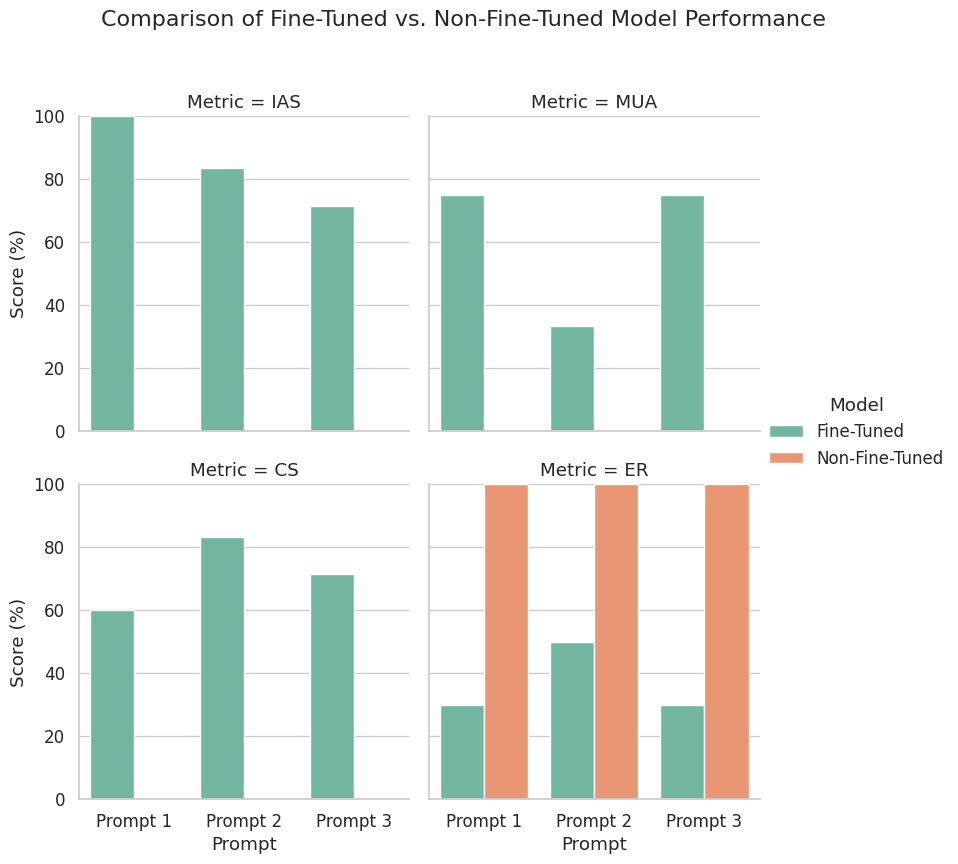

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Data from the comparison table
data = {
    'Prompt': ['Prompt 1', 'Prompt 1', 'Prompt 2', 'Prompt 2', 'Prompt 3', 'Prompt 3'],
    'Model': ['Fine-Tuned', 'Non-Fine-Tuned', 'Fine-Tuned', 'Non-Fine-Tuned', 'Fine-Tuned', 'Non-Fine-Tuned'],
    'IAS': [100.00, 0.00, 83.33, 0.00, 71.43, 0.00],
    'MUA': [75.00, 0.00, 33.33, 0.00, 75.00, 0.00],
    'CS': [60.00, 0.00, 83.33, 0.00, 71.43, 0.00],
    'ER': [30.00, 100.00, 50.00, 100.00, 30.00, 100.00]
}

# Create DataFrame
df = pd.DataFrame(data)

# Melt the DataFrame for Seaborn (long format)
df_melted = pd.melt(df, id_vars=['Prompt', 'Model'], value_vars=['IAS', 'MUA', 'CS', 'ER'],
                    var_name='Metric', value_name='Score')

# Set Seaborn style
sns.set(style="whitegrid", font_scale=1.1)  # General font size for plot

# Create faceted bar plot
g = sns.catplot(x='Prompt', y='Score', hue='Model', col='Metric', kind='bar',
                data=df_melted, height=4, aspect=1, col_wrap=2, palette='Set2')

# Customize plot
g.fig.suptitle('Comparison of Fine-Tuned vs. Non-Fine-Tuned Model Performance', fontsize=16, y=1.08)
g.set_axis_labels('Prompt', 'Score (%)')
g.set(ylim=(0, 100))

# Remove the default legend created by catplot
if g._legend:
    g._legend.remove

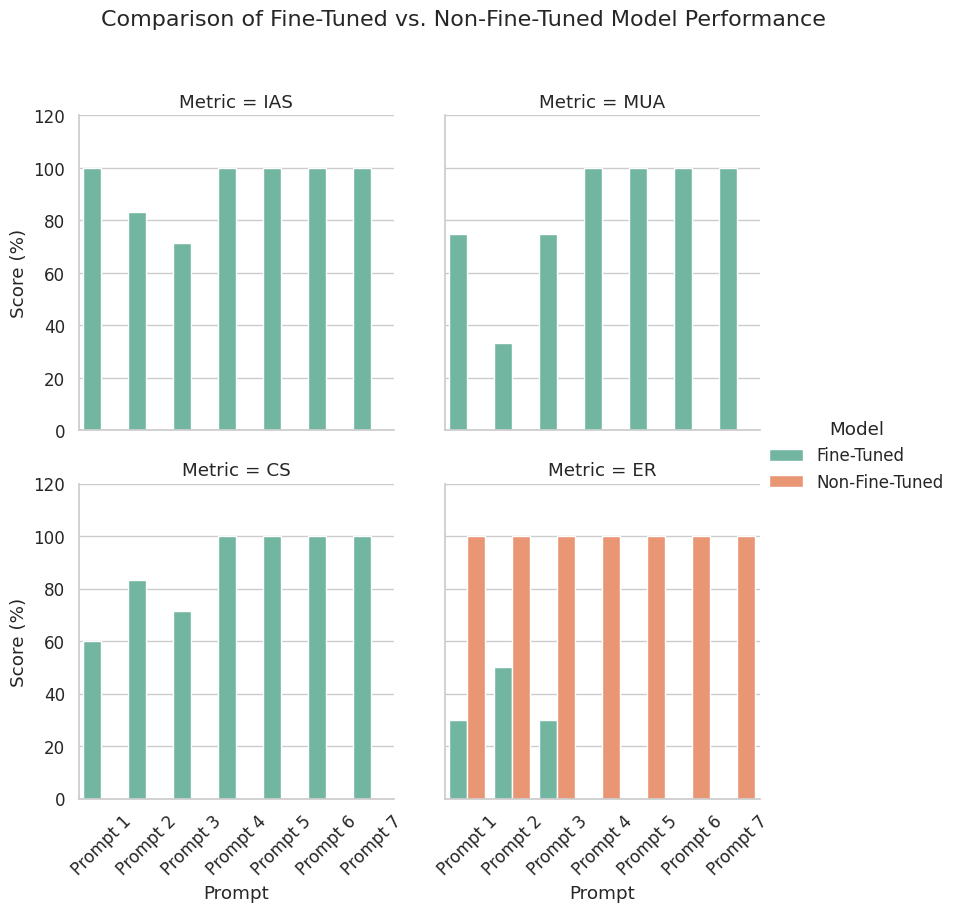

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Updated data from the comparison table
data = {
    'Prompt': ['Prompt 1', 'Prompt 1', 'Prompt 2', 'Prompt 2', 'Prompt 3', 'Prompt 3',
               'Prompt 4', 'Prompt 4', 'Prompt 5', 'Prompt 5', 'Prompt 6', 'Prompt 6', 'Prompt 7', 'Prompt 7'],
    'Model': ['Fine-Tuned', 'Non-Fine-Tuned', 'Fine-Tuned', 'Non-Fine-Tuned', 'Fine-Tuned', 'Non-Fine-Tuned',
              'Fine-Tuned', 'Non-Fine-Tuned', 'Fine-Tuned', 'Non-Fine-Tuned', 'Fine-Tuned', 'Non-Fine-Tuned', 'Fine-Tuned', 'Non-Fine-Tuned'],
    'IAS': [100.00, 0.00, 83.33, 0.00, 71.43, 0.00,
            100.00, 0.00, 100.00, 0.00, 100.00, 0.00, 100.00, 0.00],
    'MUA': [75.00, 0.00, 33.33, 0.00, 75.00, 0.00,
            100.00, 0.00, 100.00, 0.00, 100.00, 0.00, 100.00, 0.00],
    'CS': [60.00, 0.00, 83.33, 0.00, 71.43, 0.00,
           100.00, 0.00, 100.00, 0.00, 100.00, 0.00, 100.00, 0.00],
    'ER': [30.00, 100.00, 50.00, 100.00, 30.00, 100.00,
           0.00, 100.00, 0.00, 100.00, 0.00, 100.00, 0.00, 100.00]
}

# Create DataFrame
df = pd.DataFrame(data)

# Melt the DataFrame for Seaborn (long format)
df_melted = pd.melt(df, id_vars=['Prompt', 'Model'], value_vars=['IAS', 'MUA', 'CS', 'ER'],
                    var_name='Metric', value_name='Score')

# Set Seaborn style
sns.set(style="whitegrid", font_scale=1.1)  # General font size for plot

# Create faceted bar plot
g = sns.catplot(x='Prompt', y='Score', hue='Model', col='Metric', kind='bar',
                data=df_melted, height=4, aspect=1, col_wrap=2, palette='Set2')

# Customize plot
g.fig.suptitle('Comparison of Fine-Tuned vs. Non-Fine-Tuned Model Performance', fontsize=16, y=1.08)
g.set_axis_labels('Prompt', 'Score (%)')
g.set(ylim=(0, 120))  # Adjusted ylim to accommodate 100% with padding

# Rotate x-axis labels for readability
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45)

# Adjust layout to prevent label cutoff
#g.fig.tight_layout()

# Remove the default legend created by catplot
"""if g._legend:
    g._legend.remove()"""

# Save and display the plot
plt.savefig('performance_comparison_updated_metrics.png', dpi=300, bbox_inches='tight')
plt.show()